# Integration of spatial transcriptomics data - Illumina
# Scanpy - BBKNN

## Florian Leuschner spatial (prelim data by Xue 4 slices of the same animal/heart @ 3 days after MI)


In [62]:
# modules

import os
import sys
import logging
import json

from collections import defaultdict

def get_ipython_logger(logging_level='DEBUG', format_str='%(levelname)-8s : %(message)s'):

    level = logging.getLevelName(logging_level)
    formatter = logging.Formatter(format_str)
    
    logger = logging.getLogger()
    logger.setLevel(level)

    # clear whatever handlers were there
    while len(logger.handlers):
        logger.removeHandler(logger.handlers[0])
    
    #h_out = logging.StreamHandler(sys.stdout)
    h_err = logging.StreamHandler(sys.stderr)

    #logger.addHandler(h_out)
    logger.addHandler(h_err)

    for h in logger.handlers:
        h.setFormatter(formatter)

    return logger

logger = get_ipython_logger(logging_level='INFO')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [63]:
import scanpy as sc

import anndata

import numpy as np
import pandas as pd
import scipy as sp
import scipy.io

import bbknn
import scanorama

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)


scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.ERROR) 

from matplotlib import colors

# from Scrublet
def darken_cmap(cmap, scale_factor):
    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii,0] = curcol[0] * scale_factor
        cdat[ii,1] = curcol[1] * scale_factor
        cdat[ii,2] = curcol[2] * scale_factor
        cdat[ii,3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap
cmaps = darken_cmap(plt.cm.Reds, 0.9)

bone_reversed = plt.cm.get_cmap('bone_r')
copper_reversed = plt.cm.get_cmap('copper_r')
summer_reversed = plt.cm.get_cmap('summer_r')

In [65]:
# functions

def p_scatter(adata, x='n_counts', y='n_genes', hue='pct_mt', 
              xl='Count depth (raw)', yl='Number of genes', title='Fraction MT counts',
              mxx=None, mxy=None, show=False):
    ax = sc.pl.scatter(adata,
                       x, 
                       y, 
                       color=hue, 
                       show=show)
    ax.set_title(title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    if mxx is not None:
        ax.set_xlim(0, mxx)
    if mxy is not None:
        ax.set_ylim(0, mxy)
        
    fig = ax.get_figure()
    return fig

def p_hist(adata, stat='count', x1='n_genes', x2='n_counts', x3='pct_mt', 
           xl1='No. of genes per cell', xl2='Counts per cell', xl3='MT read fraction per cell'):
    
    from matplotlib.offsetbox import AnchoredText
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
    
    d = sns.histplot(adata.obs[x1], kde=True, ax=ax1, stat=stat)
    ax1.axvline(np.median(adata.obs[x1]), color='k', linestyle='--')
    ax1.set_ylabel('')
    ax1.set_yticklabels([])
    
    x = d.lines[0].get_xdata() 
    y = d.lines[0].get_ydata() 
    maxid = np.argmax(y) 
    anc = AnchoredText(f"Median {int(np.median(adata.obs[x1]))}\nPeak {int(x[maxid])}\nMode {adata.obs[x1].mode().tolist()[0]}", 
                       loc="upper right", frameon=False, prop=dict(size=10))
    ax1.add_artist(anc)
    
    d = sns.histplot(adata.obs[x2], kde=True, ax=ax2, stat=stat)
    ax2.axvline(np.median(adata.obs[x2]), color='k', linestyle='--')
    ax2.set_ylabel('')
    ax2.set_yticklabels([])
    
    x = d.lines[0].get_xdata() 
    y = d.lines[0].get_ydata() 
    maxid = np.argmax(y) 
    anc = AnchoredText(f"Median {int(np.median(adata.obs[x2]))}\nPeak {int(x[maxid])}\nMode {adata.obs[x2].mode().tolist()[0]}", 
                       loc="upper right", frameon=False, prop=dict(size=10))
    ax2.add_artist(anc)
    
    d = sns.histplot(adata.obs[x3], kde=True, ax=ax3, stat=stat)
    ax3.axvline(np.median(adata.obs[x3]), color='k', linestyle='--')
    ax3.set_ylabel('')
    ax3.set_yticklabels([])
    
    x = d.lines[0].get_xdata() 
    y = d.lines[0].get_ydata() 
    maxid = np.argmax(y) 
    anc = AnchoredText(f"Median {np.median(adata.obs[x3]):.2}\nPeak {x[maxid]:.2}\nMode {adata.obs[x3].mode().tolist()[0]:.2}", 
                       loc="upper left", frameon=False, prop=dict(size=10))
    ax3.add_artist(anc)
    
    ax1.title.set_text(xl1)
    ax2.title.set_text(xl2)
    ax3.title.set_text(xl3)
    
    return fig


In [66]:
def filter_by_expression(adata_obj, DE_column, key='rank_genes_groups'):
    
    def to_tensor(dataframe, columns = [], dtypes = {}, index = False):
        to_records_kwargs = {'index': index}
        if not columns:  # all `dataframe.columns`
            columns = dataframe.columns
        if dtypes: # pull in modifications only for dtypes listed in `columns`
            to_records_kwargs['column_dtypes'] = {}
            for column in dtypes.keys():
                if column in columns:
                    to_records_kwargs['column_dtypes'].update({column: dtypes.get(column)})
        return dataframe[columns].to_records(**to_records_kwargs)
    
    gene_names = pd.DataFrame(adata_obj.uns[key]['names'])
    fraction_in_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )
    fraction_notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )
    allin_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )
    allnotin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )

    for cluster_number in fraction_in_cluster_matrix.columns:
        dummy = adata_obj.raw.to_adata()
        dummy = dummy[:, adata_obj.uns[key]['names'][cluster_number].tolist()]
        
        subset_cluster = dummy[dummy.obs[DE_column].isin([cluster_number])]
        subset_notin_cluster = dummy[np.logical_not(dummy.obs[DE_column].isin([cluster_number]))]
   
        # Percent of cluster expressing
        if subset_cluster.shape[0] != 0:
            total_incluster = subset_cluster.shape[0]
        else: 
            total_incluster = np.nan

        if subset_notin_cluster.shape[0] != 0:
            total_outcluster = subset_notin_cluster.shape[0]
        else: 
            total_outcluster = np.nan
        
        fraction_in_cluster_matrix[cluster_number] = [(subset_cluster.X[:,gene_toanalyze].count_nonzero()/total_incluster) for gene_toanalyze in fraction_in_cluster_matrix.index]
        fraction_notin_cluster_matrix[cluster_number] = [(subset_notin_cluster.X[:,gene_toanalyze].count_nonzero()/total_outcluster) for gene_toanalyze in fraction_notin_cluster_matrix.index]

        # expression level (only by expressed)
        # in_cluster_expr_matrix[cluster_number] = [(subset_cluster.X[:,gene_toanalyze][subset_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in in_cluster_expr_matrix.index]
        # notin_cluster_matrix[cluster_number] = [(subset_notin_cluster.X[:,gene_toanalyze][subset_notin_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in notin_cluster_matrix.index]
    
        # expression_all in cluster
        allin_cluster_expr_matrix[cluster_number] = [(subset_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allin_cluster_expr_matrix.index]
        allnotin_cluster_matrix[cluster_number] = [(subset_notin_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allnotin_cluster_matrix.index]

    # generate results table
    result = adata_obj.uns[key]
    groups = result['names'].dtype.names
    result['pc_cells_in'] = to_tensor(fraction_in_cluster_matrix)
    result['pc_cells_out'] = to_tensor(fraction_notin_cluster_matrix)
    result['expr_in'] = to_tensor(allin_cluster_expr_matrix)
    result['expr_out'] = to_tensor(allnotin_cluster_matrix)
    
    results =pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges', 'pc_cells_in', 'pc_cells_out', "expr_in", "expr_out"]})

    return results


def makevector_topmarkers(anndata, top_n, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30, key='rank_genes_groups'):
    results=anndata.uns[key]
    clusters = results['names'].dtype.names
    top_genes=[]
    for cluster in clusters:
        topgenes_cluster=results['names'][cluster][np.where((results['logfoldchanges'][cluster]>=ldFC_cutoff) & (results['pvals_adj'][cluster]<(pvals_adj_cutoff)))][0:top_n]
        top_genes.extend(topgenes_cluster)
    return(top_genes)

In [67]:
def read_and_qc(sample, library_id, dirloc, outloc,
                mt_genes, mt_frac_thr,
                min_counts, max_counts, min_genes, max_genes, min_cells,
                plot=False, no_qc=False):
    
    # load data into AnnData fmt
    # use the built-in read_visium
    # genome=None Filter expression to genes within this genome
    # source_image_path=None Path to the high-resolution tissue image spatial/tissue_hires_image.png ?
    # load_images=True by default
    adata = sc.read_visium(os.path.join(dirloc, sample, 'outs'),
                           count_file='filtered_feature_bc_matrix.h5',
                           library_id=library_id) 
    adata.var_names_make_unique()
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['n_genes'] = (adata.X > 0).sum(1)
    mito_genes = adata.var_names.str.startswith(mt_genes)
    adata.obs['pct_mt'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    
    logger.info(f"{sample}: View of AnnData object with n_obs × n_vars {adata.shape}")
    
    if plot:
        fig = p_scatter(adata)
        filen = os.path.join(outloc, 'results', 'figures', f"scatter_pre_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")

        fig = p_hist(adata, xl1='No. of genes per spot', xl2='Counts per spot')
        filen = os.path.join(outloc, 'results', 'figures', f"hist_pre_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")

        logger.info(f"{name}: View of AnnData object with n_obs × n_vars {adata.shape}")
        
    if no_qc:
        return adata
        
    # filter
    adata = adata[adata.obs['pct_mt'] < mt_frac_thr]
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_cells(adata, max_counts=max_counts)
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, max_genes=max_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    if plot:
        fig = p_scatter(adata)
        filen = os.path.join(outloc, 'results', 'figures', f"scatter_post_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")

        fig = p_hist(adata, xl1='No. of genes per spot', xl2='Counts per spot')
        filen = os.path.join(outloc, 'results', 'figures', f"hist_post_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")
    
    logger.info(f"{sample}: View of AnnData object with n_obs × n_vars {adata.shape}")
        
    return adata


In [68]:
# I/O

dirloc = '/prj/Florian_Leuschner_spatial/Illumina/VX06_A006200151/cellranger'
outloc = '/prj/Florian_Leuschner_spatial/analysis/Illumina'

outname = 'bbknn'

# Normalization standard workflow
# We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes. 
# The variance in molecular counts across spots is not just technical in nature, but also is dependent on the tissue anatomy.
# More appropriate methods such as SCTransform should probably be used.
target_sum = 1e4

# Read the data into anndata objects
# use filtered visium dataset, the output of spaceranger that contains only spots within the tissue slice
samples = !ls $dirloc | grep -v txt
slides = []
for s in samples:
    slide = read_and_qc(s, s.split('_')[1], dirloc=dirloc, outloc=outloc,
                        mt_genes='mt-', mt_frac_thr=0.4,
                        min_counts=250, max_counts=18000, min_genes=250, max_genes=5000, min_cells=2,
                        plot=False, no_qc=True)
    # # first concatenate, then qc, normalise, and integrate
    # slide.layers['counts'] = slide.X.copy() # if subset=True, this is also sliced, only raw atribute is safe
    # sc.pp.normalize_total(slide, 
    #                       target_sum=target_sum, 
    #                       exclude_highly_expressed=True)
    # sc.pp.log1p(slide)
    # slide.raw = slide
    # sc.pp.highly_variable_genes(slide, subset=False) 

    slides.append(slide)
    

reading /prj/Florian_Leuschner_spatial/Illumina/VX06_A006200151/cellranger/VX06_A1_149524/outs/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
INFO     : VX06_A1_149524: View of AnnData object with n_obs × n_vars (1993, 32285)
reading /prj/Florian_Leuschner_spatial/Illumina/VX06_A006200151/cellranger/VX06_B1_149525/outs/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
INFO     : VX06_B1_149525: View of AnnData object with n_obs × n_vars (1958, 32285)
reading /prj/Florian_Leuschner_spatial/Illumina/VX06_A006200151/cellranger/VX06_C1_149526/outs/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable 

In [75]:
# perform additional filtering 
# either here before concatenating, or first concatenate, and filter afterwards

mt_frac_thr = 0.4
min_counts = {'VX06_A1_149524': 250, 
              'VX06_B1_149525': 250, 
              'VX06_C1_149526': 500, 
              'VX06_D1_149527': 500}
max_counts = {'VX06_A1_149524': 6500, 
              'VX06_B1_149525': 11000, 
              'VX06_C1_149526': 15000, 
              'VX06_D1_149527': 18000}
min_genes = {'VX06_A1_149524': 250, 
             'VX06_B1_149525': 250, 
             'VX06_C1_149526': 500, 
             'VX06_D1_149527': 500}
max_genes = {'VX06_A1_149524': 2500, 
             'VX06_B1_149525': 3500, 
             'VX06_C1_149526': 4000, 
             'VX06_D1_149527': 5000}
min_cells = 3

for i, name in enumerate(samples):
    adata = slides[i]
    adata = adata[adata.obs['pct_mt'] < mt_frac_thr]
    
    sc.pp.filter_cells(adata, min_counts=min_counts[name])
    sc.pp.filter_cells(adata, max_counts=max_counts[name])
    sc.pp.filter_cells(adata, min_genes=min_genes[name])
    sc.pp.filter_cells(adata, max_genes=max_genes[name])
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    slides[i] = adata

filtered out 20 cells that have less than 250 counts
Trying to set attribute `.obs` of view, copying.
filtered out 14 cells that have more than 6500 counts
filtered out 11 cells that have less than 250 genes expressed
filtered out 8 cells that have more than 2500 genes expressed
filtered out 18432 genes that are detected in less than 3 cells
filtered out 23 cells that have less than 250 counts
Trying to set attribute `.obs` of view, copying.
filtered out 7 cells that have more than 11000 counts
filtered out 6 cells that have less than 250 genes expressed
filtered out 17559 genes that are detected in less than 3 cells
filtered out 8 cells that have less than 500 counts
Trying to set attribute `.obs` of view, copying.
filtered out 4 cells that have more than 15000 counts
filtered out 12 cells that have less than 500 genes expressed
filtered out 8 cells that have more than 4000 genes expressed
filtered out 17037 genes that are detected in less than 3 cells
filtered out 8 cells that have l

## Normalisation

We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes. 
The variance in molecular counts across spots is not just technical in nature, but also is dependent on the tissue anatomy.
More appropriate methods such as SCTransform should probably be used.


### BBKNN Integration

BBKNN has the option to immediately slot into the spot occupied by scanpy.neighbors()

You can provide which adata.obs column to use for batch discrimination via the batch_key parameter. This defaults to 'batch', which is created by scanpy when you merge multiple AnnData objects (e.g. if you were to import multiple samples separately and then concatenate them).



In [78]:
# first concatenate - 
# combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    join='inner', 
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            slides[0].uns["spatial"],
            slides[1].uns["spatial"],
            slides[2].uns["spatial"],
            slides[3].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [83]:
# save the counts in case, we need the normalized counts in raw for DGE
counts_adata = adata.copy()

# Normalization standard workflow
target_sum = 1e4
sc.pp.normalize_total(adata, 
                      target_sum=target_sum, 
                      exclude_highly_expressed=True)
sc.pp.log1p(adata)

# the idea is to avoid including batch specific genes in the analysis.
sc.pp.highly_variable_genes(adata, batch_key="library_id")

# subset for variable genes - do this beforehand if subset=True to keep full dimension safe
# and in any case, before filtering for HVG
adata.raw = adata

logger.info(f"View of AnnData object with n_obs × n_vars {adata.shape}")

# keep the union
adata = adata[:,adata.var.highly_variable_nbatches > 0]
# or e.g. genes that are variable in at least 2 datasets
# adata = adata[:,adata.var.highly_variable_nbatches > 2]

logger.info(f"View of AnnData object with n_obs × n_vars {adata.shape}")

# we should update QC metrics after filtering!
# here

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3']
    finished (0:00:00)
extracting highly variable genes
... storing 'feature_types' as categorical
... storing 'genome' as categorical
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
INFO     : View of AnnData object with n_obs × n_vars (7708, 13528)
INFO     : View of AnnData object with n_obs × n_vars (7708, 8076)


In [84]:
adata

View of AnnData object with n_obs × n_vars = 7708 × 8076
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'pct_mt', 'library_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-A1', 'n_cells-B1', 'n_cells-C1', 'n_cells-D1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [85]:
adata.raw.shape

(7708, 13528)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


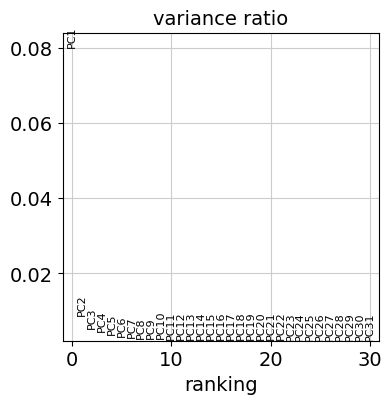

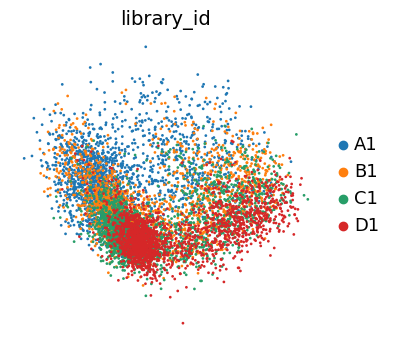

In [86]:
sc.tl.pca(adata, 
          svd_solver='arpack', 
          use_highly_variable=True)

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color="library_id")

In [91]:
# improved batch mixing by introducing ridge regression into the workflow
# Regressing out technical effect while including a biological grouping into the procedure is 
# insufficient to remove batch effect from a UMAP based on a regular neighbour graph, but helps mix batches
# better when used as input for BBKNN. One may not be armed in a biological grouping at the time of analysis, in which 
# case a coarse clustering (aiming to feature as many batches as possible per cluster) can be used in its place. This results in the following analysis flow:
# bbknn
# clustering
# ridge regression
# pca
# bbknn

# e.g. https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/demo.ipynb
# other exmaples at https://github.com/Teichlab/bbknn

# see also e.g. ~/runs/LZ_PR2B_rewiring/notebooks/analysis_merged_prelim/analysis_merged_prelim.ipynb

# after bnknn  `.X` now features regression residuals
# `.layers['X_explained']` stores the expression explained by the technical effect

# >> use copy=True when calling to copy object and keep adata safe for comparison

n_pcs = 10

bbknn.bbknn(adata, batch_key='library_id', neighbors_within_batch=15, n_pcs=n_pcs, trim=20)

resolution = 0.4
key_added = 'leiden_rr'

sc.tl.leiden(adata, 
             resolution=resolution, 
             key_added=key_added)
bbknn.ridge_regression(adata, batch_key=['library_id'], confounder_key=['leiden_rr'])
sc.tl.pca(adata, 
          svd_solver='arpack', 
          use_highly_variable=True) # reuse same number of components here
bbknn.bbknn(adata, batch_key='library_id', neighbors_within_batch=15, n_pcs=n_pcs, trim=20)


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_rr', the cluster labels (adata.obs, categorical) (0:00:00)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Neighbours - Clustering

In [92]:
# BBKNN replaced neighbours
sc.tl.umap(adata, min_dist=0.1, spread=.6)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [93]:
resolution = 0.3
sc.tl.leiden(adata, 
             resolution=resolution, 
             key_added="clusters")
adata.obs['clusters'].value_counts()

running Leiden clustering
    finished: found 4 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


0    2647
1    2334
2    1640
3    1087
Name: clusters, dtype: int64

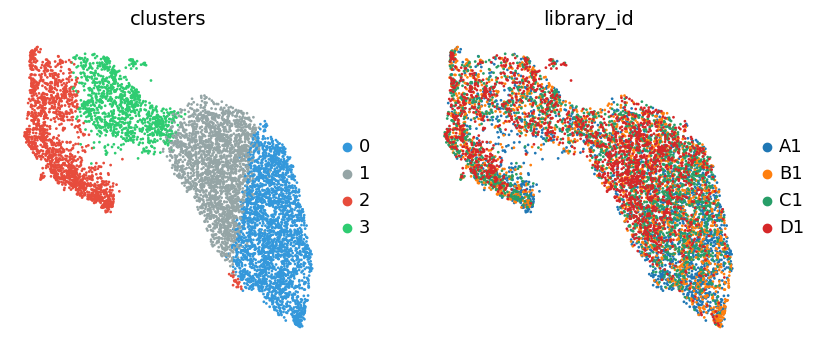

In [94]:
adata.uns['clusters_colors'] = ["#3498db", "#95a5a6", "#e74c3c", "#2ecc71"]
sc.pl.umap(adata, color=["clusters", "library_id"])

In [95]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata.uns["clusters_colors"])
)

[<AxesSubplot:title={'center':'A1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'B1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'C1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'D1'}, xlabel='spatial1', ylabel='spatial2'>]

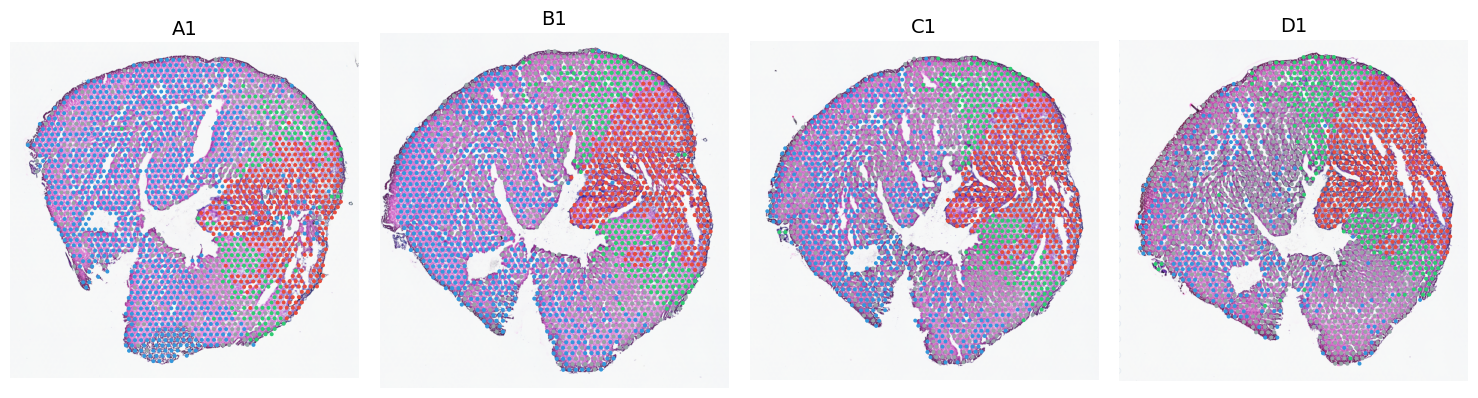

In [96]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))

for i, library in enumerate(
    ['A1', 'B1', 'C1', 'D1']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        title=library,
        #size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [97]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_clusters_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

[<AxesSubplot:title={'center':'A1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'B1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'C1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'D1'}, xlabel='spatial1', ylabel='spatial2'>]

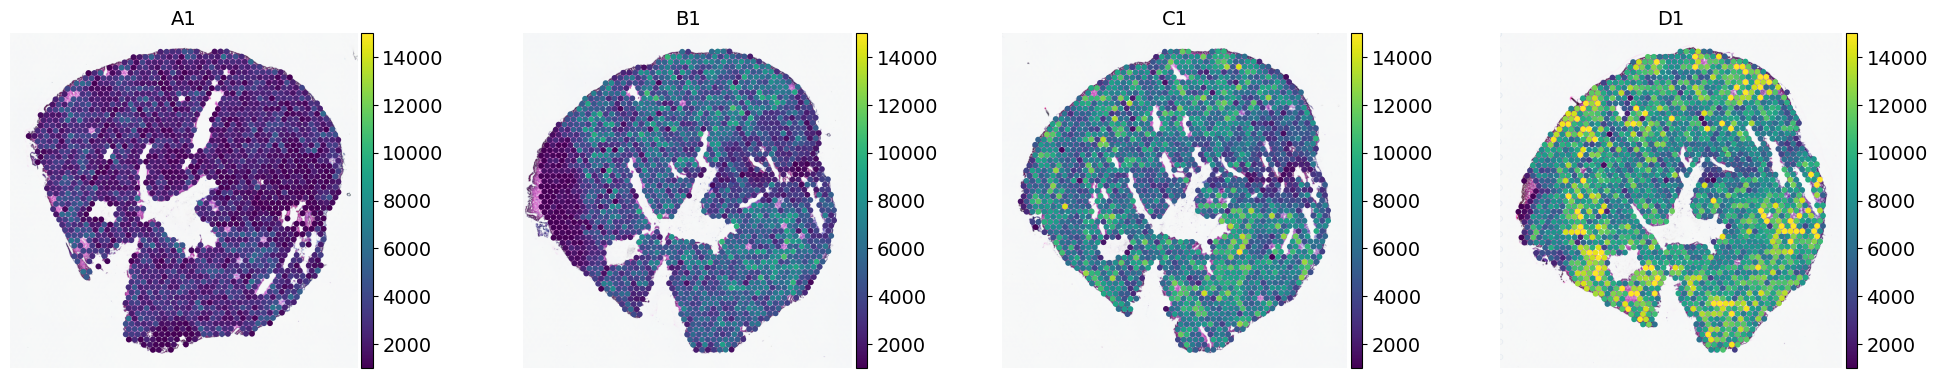

In [98]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, library in enumerate(
    ['A1', 'B1', 'C1', 'D1']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="n_counts",
        size=1.5,
        title=library,
        vmin=1000,
        vmax=15000,
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [99]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_counts_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

[<AxesSubplot:title={'center':'A1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'B1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'C1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'D1'}, xlabel='spatial1', ylabel='spatial2'>]

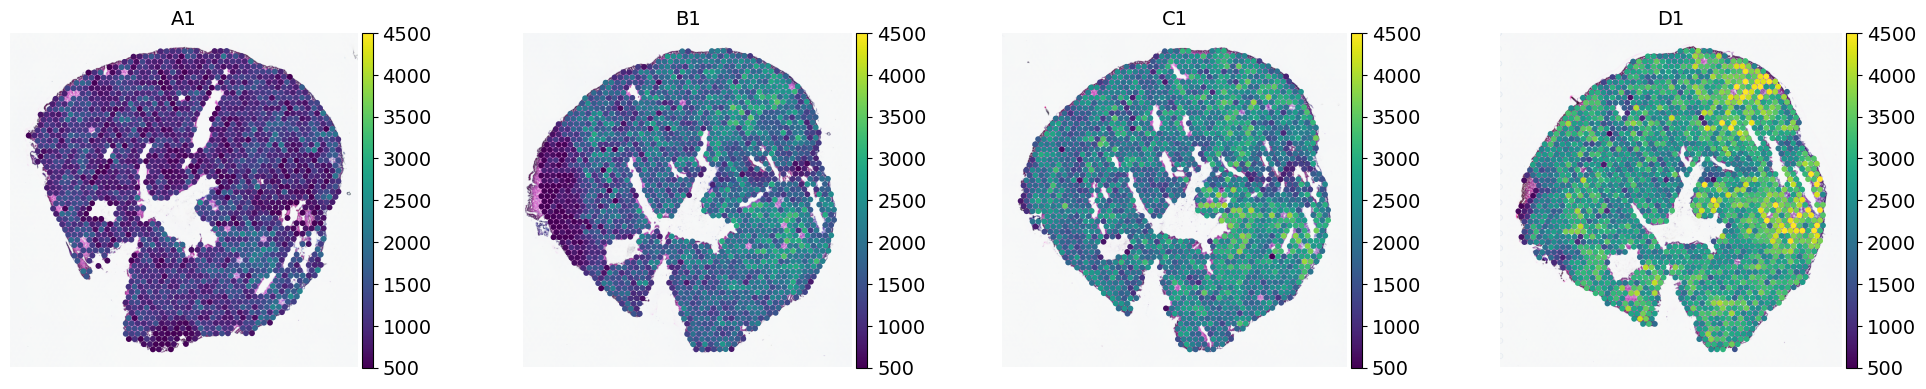

In [100]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, library in enumerate(
    ['A1', 'B1', 'C1', 'D1']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="n_genes",
        size=1.5,
        title=library,
        vmin=500,
        vmax=4500,
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [101]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_genes_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

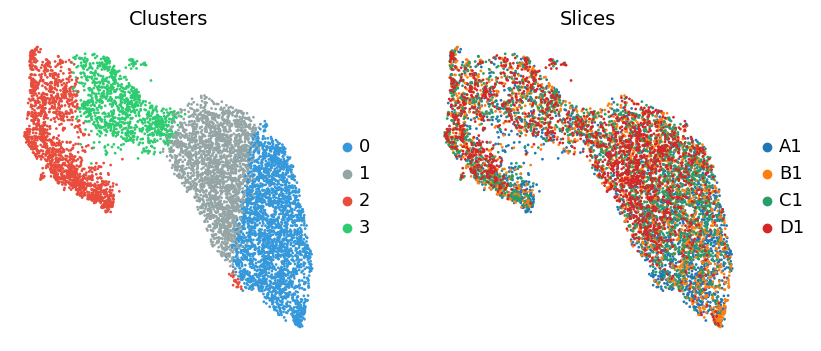

In [102]:
sc.pl.umap(adata, color=["clusters", "library_id"], title=['Clusters', 'Slices'], save=f'_{outname}.png')

## Data integration and label transfer from scRNA-seq dataset (perform label transfers between an annotated scRNA-seq dataset and an unannotated Visium dataset)

Workflow: (i) The integration task will be performed with Scanorama: each Visium dataset can be integrated with a given scRNA-seq dataset, (ii) Subset the spatial anndata to (approximately) selects only spots belonging to the region relevant to the scRNA-seq if applicable, (iii) Run integration with Scanorama, and (iv) Concatenate datasets and assign integrated embeddings to anndata objects.

See [Data integration and label transfer from scRNA-seq dataset](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html#Data-integration-and-label-transfer-from-scRNA-seq-dataset).

For label transfer, deconvolution methods can also be used, but see https://satijalab.org/seurat/articles/spatial_vignette.html

*We consistently found superior performance using integration methods (as opposed to deconvolution methods).
We therefore apply the ‘anchor’-based integration workflow introduced in Seurat v3, that enables the probabilistic transfer of annotations from a reference to a query set. We first load the (reference scRNA-seq) data, pre-process the scRNA-seq reference, and then perform label transfer.*


## Marker genes & cluster annotation

Use the Visium data only, and selected known markers.


In [103]:
# our markers
with open("/home/eboileau/resources/markers.json", "r") as f:
    all_markers = json.load(f)
all_markers = json.loads(all_markers)

# collect selected markers, incl. human
selected_markers = defaultdict(set)

for m in ['CM', 'FB']:
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][0]['markers'][m]])
    
for m in all_markers['heart'][1]['markers'].keys():
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][1]['markers'][m]])
    
for m in ['EC', 'FB', 'NC', 'SMC', 'PC', 'MC', 'AC']:
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][2]['markers']['markers_canonical'][m]])
# drop all_markers['heart'][2]['markers']['markers_immune'].keys()

for m in ['PC', 'MP', 'AC', 'SMC', 'NC', 'LC']:
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][3]['markers'][m]])
    
for m in ['VP', 'EC', 'FB', 'PC', 'MP', 'MY', 'LC', 'AC', 'NC', 'MC', 'SMC']:
    selected_markers[m].update(all_markers['heart'][4]['markers'][m])
    
selected_markers.keys()
# all_markers['description']

dict_keys(['CM', 'FB', 'EC', 'MP', 'SMC', 'NC', 'PC', 'MC', 'AC', 'LC', 'VP', 'MY'])

In [104]:
# after a first check, we subset the most relevant for/expressed in our data
for key in selected_markers.keys():
    selected_markers[key] = {m for m in selected_markers[key] if m in adata.raw.var_names}
    

In [105]:
markers = {'CM': ['Tnnt2', 'Myl2', 'Myl3', 'Myh6', 'Myh7', 'Ttn', 'Actc1', 'Actn2', 'Fabp3', 'Nppa', 'Ankrd1'],
           'MFB': ['Col1a2', 'Acta2', 'Igfbp7', 'Vim', 'Serpinh1', 'Fbln2', 'Sparc', 'Fn1'],
           'EC': ['Postn', 'Tmsb10', 'Cdh5', 'Pecam1'],
           'IM': ['Lyz2', 'C1qa', 'C1qb', 'Cd47', 'Cd74', 'Cd36', 'B2m']}

In [106]:
markers['Fibrosis'] = ['Nlrp3', 'Mmp2', 'Mmp6', 'Ccn2', 'Ctgf', 'Agt']
markers['Fibrosis'] = [a for a in markers['Fibrosis'] if a in adata.var_names]
markers['Fibroblast'] = ['Tcf21', 'Wt1', 'Tbx18', 'Tie2']
markers['Fibroblast'] = [a for a in markers['Fibroblast'] if a in adata.var_names]
markers['Inflammation'] = ['Hck', 'Cd53', 'Tyrobp', 'Clu']
markers['Inflammation'] = [a for a in markers['Inflammation'] if a in adata.var_names]
markers

# Mmp2, Ccn2 - fibrosis/inflammation
# Clu
# Highly consistent driver genes such as HCK, CD53 and TYROBP have been found being involved in many inflammation-related disorders.
# Clu
# genes critical for cardiac fibrosis were examined, namely, 
# Transcription factors that have been used as cardiac fibroblast markers include Tcf21, WT1, Tbx18, and Tie2

{'CM': ['Tnnt2',
  'Myl2',
  'Myl3',
  'Myh6',
  'Myh7',
  'Ttn',
  'Actc1',
  'Actn2',
  'Fabp3',
  'Nppa',
  'Ankrd1'],
 'MFB': ['Col1a2',
  'Acta2',
  'Igfbp7',
  'Vim',
  'Serpinh1',
  'Fbln2',
  'Sparc',
  'Fn1'],
 'EC': ['Postn', 'Tmsb10', 'Cdh5', 'Pecam1'],
 'IM': ['Lyz2', 'C1qa', 'C1qb', 'Cd47', 'Cd74', 'Cd36', 'B2m'],
 'Fibrosis': ['Mmp2', 'Ccn2', 'Agt'],
 'Fibroblast': ['Tcf21', 'Wt1', 'Tbx18'],
 'Inflammation': ['Hck', 'Cd53', 'Tyrobp']}

ranking genes
    finished: added to `.uns['ranked_clusters']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:36)


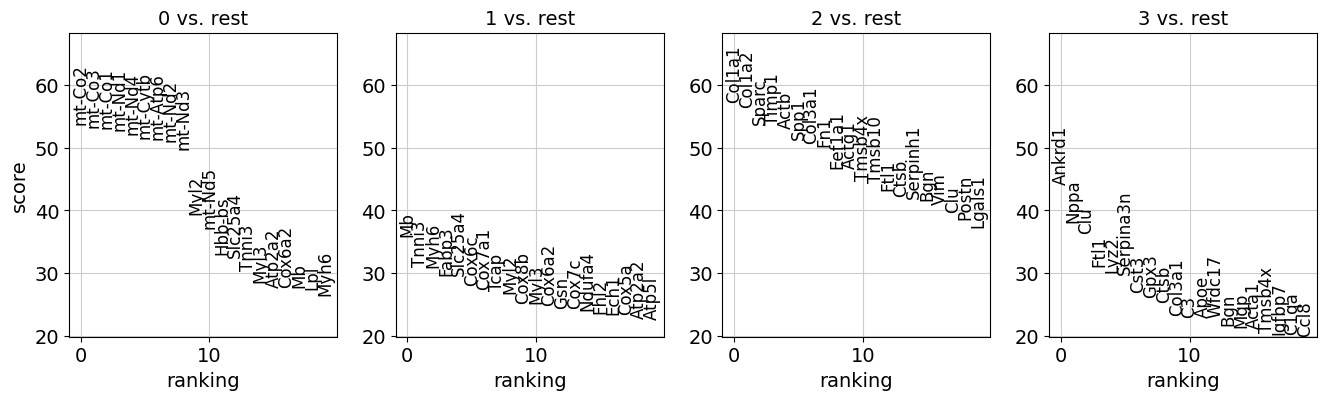

In [107]:
key_added = 'clusters'
sc.tl.rank_genes_groups(adata, 
                        groupby=key_added, 
                        key_added=f'ranked_{key_added}', 
                        method='wilcoxon', 
                        tie_correct=True,
                        use_raw=True)

sc.pl.rank_genes_groups(adata, 
                        key=f'ranked_{key_added}', 
                        fontsize=12,
                        save=f'_{outname}.png')

In [348]:
# wilcox_clusters = filter_by_expression(adata_spatial, 'clusters', key='ranked_clusters')
# wilcox_clusters.to_csv(os.path.join(dirloc, "results", "tables", f"wilcox_clusters_wide_{outname}.csv.gz"),
#                        index=False,
#                        compression='gzip')

In [109]:
dfl = []
for group in adata.uns['ranked_clusters']['names'].dtype.names:
    cols = {'names':adata.uns['ranked_clusters']['names'][group], 
            'scores':adata.uns['ranked_clusters']['scores'][group], 
            'pvals':adata.uns['ranked_clusters']['pvals'][group], 
            'pvals_adj':adata.uns['ranked_clusters']['pvals_adj'][group],
            'logfoldchanges':adata.uns['ranked_clusters']['logfoldchanges'][group],
            'clusters': group}
    dfl.append(pd.DataFrame(cols))
wilcox_clusters_long = pd.concat(dfl)
filen = os.path.join(outloc, "results", "tables", f"wilcox_clusters_long_std_{outname}.csv.gz")
wilcox_clusters_long.to_csv(filen, compression='gzip', index=False)

In [353]:
# sc.pl.rank_genes_groups_heatmap(adata_spatial, key='ranked_clusters', groups="2", n_genes=10, groupby="clusters")

In [114]:
sc.tl.dendrogram(adata, 'clusters', use_rep='X_pca')

Storing dendrogram info using `.uns['dendrogram_clusters']`


Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.2, max_out_group_fraction: 0.5


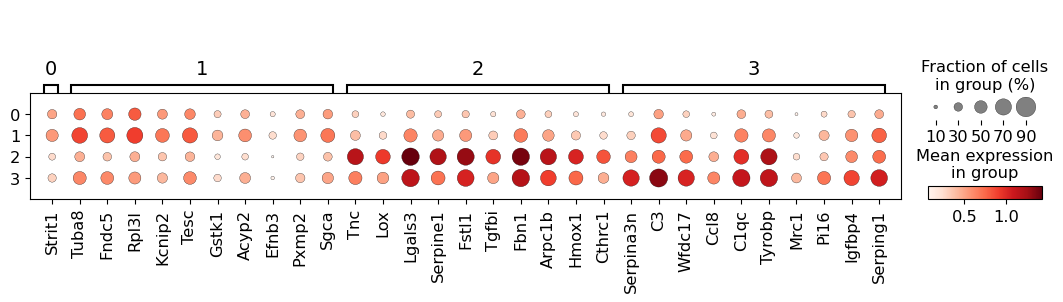

In [115]:
## Filtering of marker genes
sc.tl.filter_rank_genes_groups(adata,
                               key='ranked_clusters',
                               min_in_group_fraction=0.25,
#                                max_out_group_fraction=0.1,
                               min_fold_change=.2)
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups_filtered', dendrogram=False)

categories: 0, 1, 2, etc.
var_group_labels: CM, FB, EC, etc.


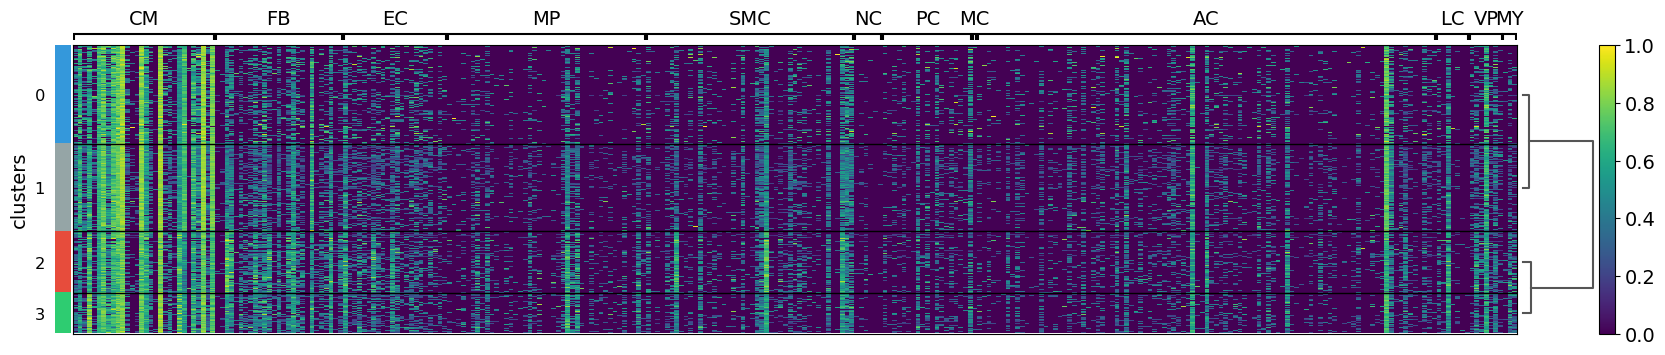

In [116]:
# sc.pl.rank_genes_groups_heatmap(adata_spatial, n_genes=10, key='ranked_clusters', show_gene_labels=True, dendrogram=False)
sc.pl.heatmap(
    adata,
    selected_markers,
    groupby='clusters',
    #layer="X_normalized_scVI",
    standard_scale="var",
    dendrogram=True,
    use_raw=True,
    figsize=(20, 4)
)

In [379]:
all_markers['description']

{'aCM': 'atrial cardiomyocyte',
 'vCM': 'ventricular cardiomyocyte',
 'CM': 'cardiomyocyte',
 'sCM': 'stressed cardiomyocyte',
 'FB': 'fibroblast',
 'EC': 'endothelial',
 'AC': 'adipocyte',
 'SMC': 'smooth muscle',
 'NC': 'neural crest',
 'LC': 'lymphocyte',
 'MP': 'macrophage',
 'PC': 'pericyte',
 'MC': 'mesothelial',
 'MY': 'myeloid',
 'VP': 'vascular progenitor',
 'AP': 'ion channels contributing to cardiac action potential',
 'GJ': 'heart gap junction channels',
 'PSC': 'pluripotent stem cells',
 'ENDO': 'definitive endoderm',
 'MESO': 'mesoderm',
 'ECTO': 'ectoderm',
 'NP': 'neural progenitor',
 'CP': 'cardiac progenitor'}

In [ ]:
# ax = sc.pl.stacked_violin(adata_spatial, selected_markers, groupby='clusters', swap_axes=True,
#                          var_group_positions=[(7, 8)], dendrogram=False)

categories: 0, 1, 2, etc.
var_group_labels: CM, MFB, EC, etc.


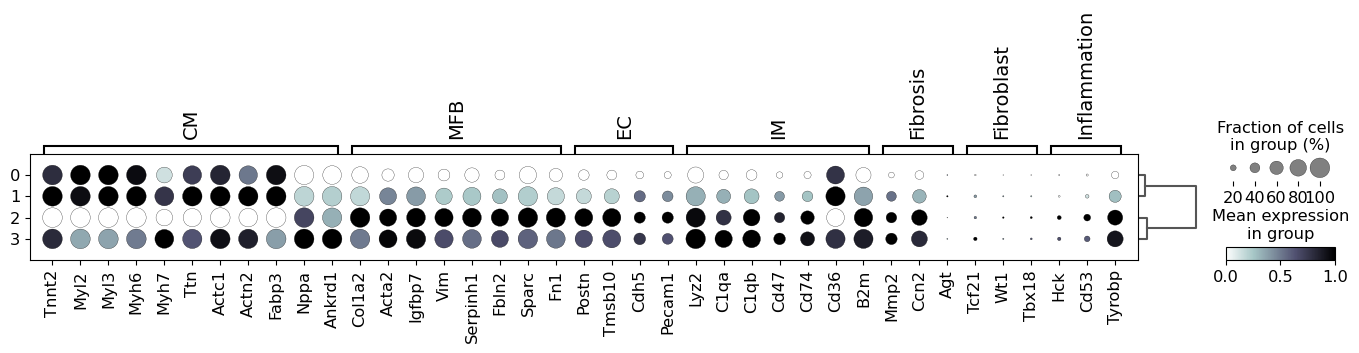

In [117]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='clusters',
    dendrogram=True,
    color_map=bone_reversed,
    swap_axes=False,
    use_raw=True, 
    standard_scale="var",
    save=f'_selected_markers_{outname}.png'
)

0     1     2     3
CM   23.0  25.0   4.0  10.0
FB    5.0   3.0  17.0  24.0
EC    7.0  10.0  11.0   9.0
MP   18.0   3.0  31.0  23.0
SMC  28.0  13.0  17.0  12.0
NC    5.0   0.0   1.0   1.0
PC   14.0  12.0   5.0   3.0
MC    1.0   0.0   0.0   0.0
AC   70.0  37.0  33.0  18.0
LC    4.0   0.0   6.0   3.0
VP    3.0   6.0   2.0   1.0
MY    0.0   0.0   3.0   3.0

<AxesSubplot:>

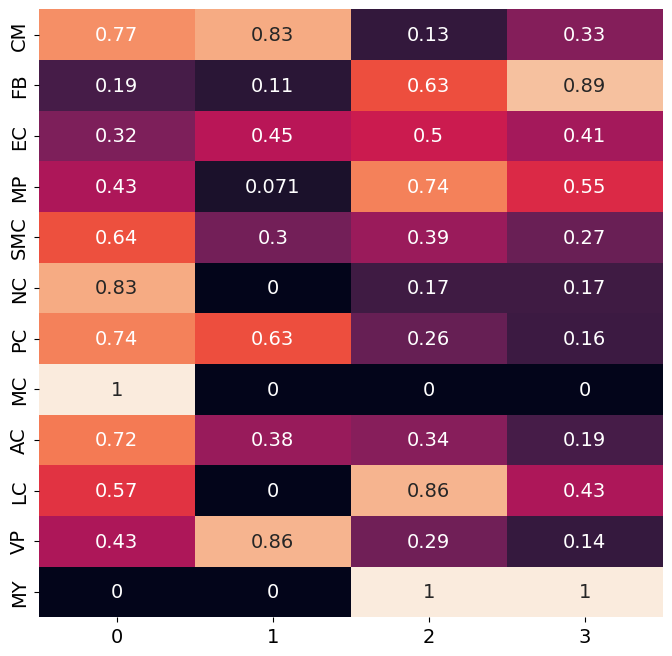

In [119]:
cell_annotation = sc.tl.marker_gene_overlap(adata, selected_markers, key='ranked_clusters',
                                            adj_pval_threshold=1e-5)
cell_annotation

cell_annotation_norm = sc.tl.marker_gene_overlap(adata, selected_markers, key='ranked_clusters', 
                                                 normalize='reference', adj_pval_threshold=1e-5)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cell_annotation_norm, cbar=False, annot=True, ax=ax)

0    1    2    3
CM            8.0  9.0  2.0  5.0
MFB           0.0  0.0  8.0  8.0
EC            0.0  0.0  4.0  2.0
IM            1.0  1.0  6.0  6.0
Fibrosis      1.0  0.0  2.0  2.0
Fibroblast    3.0  0.0  1.0  1.0
Inflammation  0.0  0.0  3.0  3.0

<AxesSubplot:>

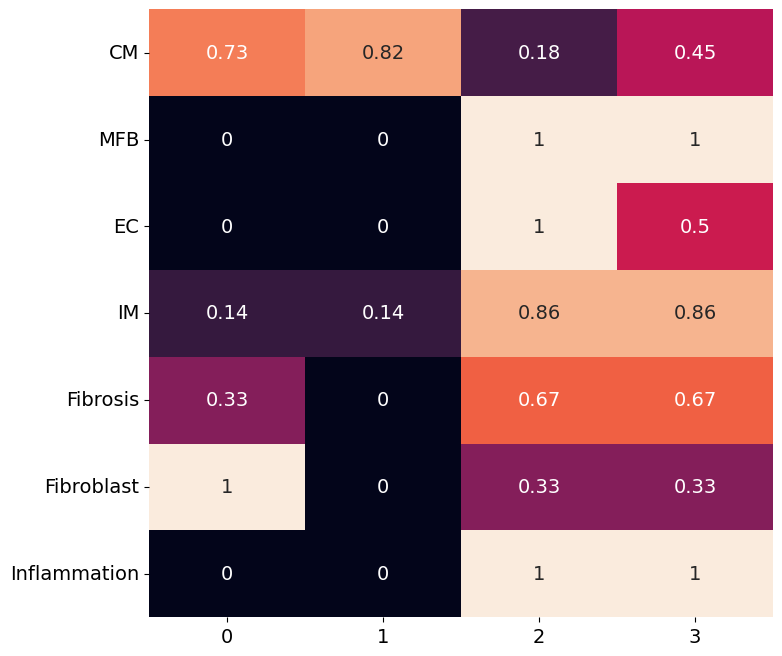

In [120]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers, key='ranked_clusters',
                                            adj_pval_threshold=1e-5)
cell_annotation

cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers, key='ranked_clusters', 
                                                 normalize='reference', adj_pval_threshold=1e-5)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cell_annotation_norm, cbar=False, annot=True, ax=ax)

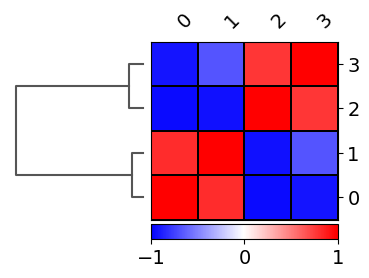

In [121]:
# we can check correlation between assigned clusters directly using
sc.pl.correlation_matrix(adata, 'clusters')

In [ ]:
# 0 = CM
# 1 = CM, fibroblast
# 2 = myofibroblast, endothelial, inflammation
# 3 = myofibroblast, inflammation

In [ ]:
# check some slices with known genes

In [122]:
# sc.pl.spatial(adata[adata.obs.library_id == 'A1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='A1', use_raw=True)
# sc.pl.spatial(adata[adata.obs.library_id == 'B1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='B1', use_raw=True)
# sc.pl.spatial(adata[adata.obs.library_id == 'C1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='C1', use_raw=True)
# sc.pl.spatial(adata[adata.obs.library_id == 'D1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='D1', use_raw=True)

In [123]:
del adata.uns['rank_genes_groups_filtered']

In [124]:
filen = os.path.join(outloc, "data", f"clusters_{outname}.h5ad")
adata.write_h5ad(filen)

### Gene set analysis

In [125]:
import gseapy

In [126]:
# ranked gene groups - wilcoxon default
pval_cutoff = 0.05
log2fc_min = 0.2

gene_sets = 'GO_Biological_Process_2021'
title = "GO BP"

# gene_sets = 'GO_Molecular_Function_2021'
# title = "GO MF"

# specify gene background, see running locally with .gmt file or gene_set dict object ???
# otherwise enrichr default background='hsapiens_gene_ensembl'

# based on ranked gene groups as above use_raw=True

for idx in adata.obs.clusters.cat.categories:
    glist = sc.get.rank_genes_groups_df(adata, group=idx, key='ranked_clusters',
                                        pval_cutoff=pval_cutoff, log2fc_min=log2fc_min)['names'].squeeze().str.strip().tolist()
    enr_res = gseapy.enrichr(gene_list=glist,
                             organism='Mouse',
                             gene_sets=gene_sets,
                             description='pathway',
                             cutoff=0.01)

    filen = os.path.join(outloc, "results", "figures", f"clust{idx}_{gene_sets}_{outname}.png")
    gseapy.barplot(enr_res.res2d, title=f"{title}, Cluster {idx}", color=adata.uns['clusters_colors'][int(idx)], ofname=filen)
    
    

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:fe0cd5986c1c575610cd92eb2433d5d4
INFO     : Done.

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:47b5884acf478dd691f8b6ffba4b05a2
INFO     : Done.

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:f8f24f4440acf2f7bee6dd465fdce563
INFO     : Done.

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:98738860bb3d55633b6d40685c6edd8a
INFO     : Done.

